In [1]:
#Importando los paquetes


import tensorflow  as tf 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D 
from keras.layers import Dropout, BatchNormalization , GlobalAveragePooling2D
from keras.regularizers import l2
from keras.applications import  ResNet50 
from keras.layers import  Flatten, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import cv2

METHOD TO LOAD THE IMAGES OF THE DATASET

In [2]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
            img = cv2.resize(img, (RESIZE,RESIZE))
            IMG.append(np.array(img))
    return IMG



LOADING THE BENIGN IMAGES

In [3]:
adenosis = np.array(Dataset_loader(r'D:\Estudio\4_Cuatro\Machine_Learning\Proyecto\dataset\BreaKHis_v1\histology_slides\breast\benign\SOB\adenosis\adenosis', 64))
fibroadenoma = np.array(Dataset_loader(r'D:\Estudio\4_Cuatro\Machine_Learning\Proyecto\dataset\BreaKHis_v1\histology_slides\breast\benign\SOB\fibroadenoma\fibroadenoma', 64))

100%|██████████| 524/524 [00:44<00:00, 11.78it/s]


LOADING THE MALIGNANT IMAGES

In [4]:
ductal_carcinoma = np.array(Dataset_loader(r'D:\Estudio\4_Cuatro\Machine_Learning\Proyecto\dataset\BreaKHis_v1\histology_slides\breast\malignant\SOB\ductal_carcinoma\ductal_carcinoma', 64))
lobular_carcinoma = np.array(Dataset_loader(r'D:\Estudio\4_Cuatro\Machine_Learning\Proyecto\dataset\BreaKHis_v1\histology_slides\breast\malignant\SOB\lobular_carcinoma\lobular_carcinoma' , 64))

100%|██████████| 427/427 [00:13<00:00, 31.08it/s]


FORMING THE BENIGN AND MALIGNANT GROUPS AND LABELLING

In [5]:
benign = np.concatenate((adenosis, fibroadenoma), axis=0)
malignant = np.concatenate((ductal_carcinoma, lobular_carcinoma), axis = 0)

benign_label = np.zeros(len(benign))
malignant_label = np.ones(len(malignant))

In [7]:
X = np.concatenate((benign, malignant), axis = 0)
Y = np.concatenate((benign_label, malignant_label), axis = 0)


CREATING THE TRAINNING AND TESTING SETS

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size= 0.70, random_state= 42)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)

X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train,num_classes = 2)
Y_test =  to_categorical(Y_test, num_classes = 2)

PLOTTINGG THE IMAGES

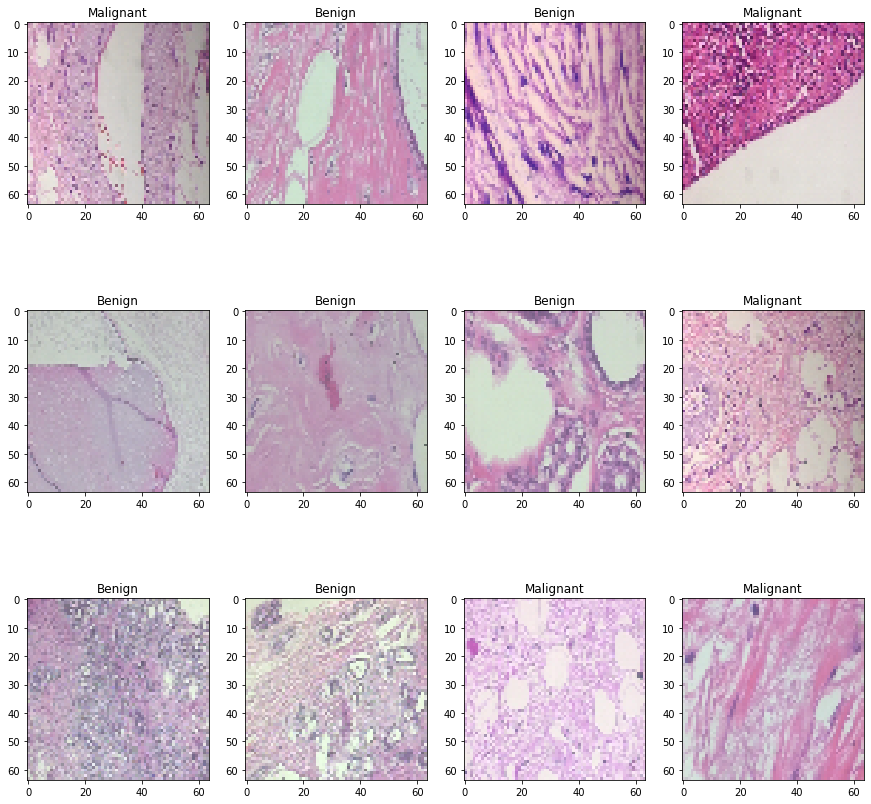

In [9]:
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

GENERATING MORE IMAGES

In [10]:
train_datagen = ImageDataGenerator( 
                                    rotation_range= 10,
                                    width_shift_range= 0.2,
                                    height_shift_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True
                                    )


CREATING THE CNN

In [10]:
cnn = Sequential()

cnn.add(Conv2D(filters = 64, padding = 'same', kernel_size= 3,
                 activation= 'relu', input_shape = (64, 64, 3)) 
        )

cnn.add(MaxPooling2D())

cnn.add(Conv2D(filters = 128, padding = 'same', kernel_size= 5,
                 activation= 'relu') 
        )

cnn.add(MaxPooling2D())
#Flattening
cnn.add(Flatten())

#Full Connection

cnn.add(Dense(units = 512, activation ='relu'))
cnn.add(Dense(2, activation = 'softmax'))
cnn.summary() 


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 512)               1

CNN WITH TRANSFER LEARNING

In [11]:
base_model = ResNet50(input_shape = (64,64, 3), include_top = False, weights = "imagenet" )

print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  175


In [12]:
cnn = Sequential() #Initialising the cnn

#Convolution
cnn.add(base_model)
            
#Pooling
cnn.add(GlobalAveragePooling2D())

#Adding a Second Convolutional layer
#Flattening
cnn.add(Dropout(0.5))

cnn.add(BatchNormalization())

#Full Connection
cnn.add(Dense(2, activation ='softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,600,002
Trainable params: 23,542,786
No

In [20]:
cnn.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_cnn = cnn.fit( 
        train_datagen.flow(X_train, Y_train, batch_size = 32),
        epochs = 10,
        validation_data = (X_test, Y_test)
)


Epoch 1/10
35/35 [==============================] - 64s 2s/step - loss: 0.5634 - accuracy: 0.7737 - val_loss: 0.4523 - val_accuracy: 0.8128
Epoch 2/10
35/35 [==============================] - 65s 2s/step - loss: 0.4537 - accuracy: 0.8057 - val_loss: 0.4347 - val_accuracy: 0.8064
Epoch 3/10
35/35 [==============================] - 65s 2s/step - loss: 0.4255 - accuracy: 0.8047 - val_loss: 0.3846 - val_accuracy: 0.8255
Epoch 4/10
35/35 [==============================] - 66s 2s/step - loss: 0.4504 - accuracy: 0.7874 - val_loss: 0.4004 - val_accuracy: 0.8319
Epoch 5/10
35/35 [==============================] - 71s 2s/step - loss: 0.4186 - accuracy: 0.8212 - val_loss: 0.3740 - val_accuracy: 0.8532
Epoch 6/10
35/35 [==============================] - 69s 2s/step - loss: 0.4285 - accuracy: 0.8230 - val_loss: 0.5394 - val_accuracy: 0.7702
Epoch 7/10
35/35 [==============================] - 65s 2s/step - loss: 0.4291 - accuracy: 0.8102 - val_loss: 0.4040 - val_accuracy: 0.8149
Epoch 8/10
35/35 [==

In [13]:
cnn.compile(optimizer= Adam(learning_rate = 1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_cnn = cnn.fit(train_datagen.flow( X_train, Y_train, batch_size = 32),  epochs=5, validation_data =( X_test, Y_test))

Epoch 1/5
35/35 [==============================] - 299s 8s/step - loss: 0.7222 - accuracy: 0.6724 - val_loss: 0.6533 - val_accuracy: 0.7000
Epoch 2/5
35/35 [==============================] - 279s 8s/step - loss: 0.4610 - accuracy: 0.8075 - val_loss: 0.4915 - val_accuracy: 0.7638
Epoch 3/5
35/35 [==============================] - 273s 8s/step - loss: 0.3594 - accuracy: 0.8586 - val_loss: 0.4203 - val_accuracy: 0.7872
Epoch 4/5
35/35 [==============================] - 272s 8s/step - loss: 0.2903 - accuracy: 0.8832 - val_loss: 0.3901 - val_accuracy: 0.8383
Epoch 5/5
35/35 [==============================] - 274s 8s/step - loss: 0.2738 - accuracy: 0.8878 - val_loss: 0.2690 - val_accuracy: 0.8702


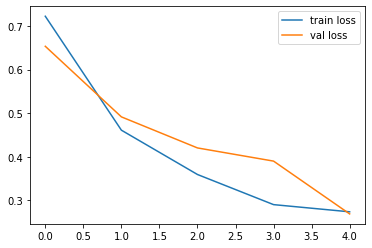

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(history_cnn.history['loss'], label = 'train loss')
plt.plot(history_cnn.history['val_loss'], label ='val loss')
plt.legend ()
plt.show()
plt.savefig ('LossVal_loss')

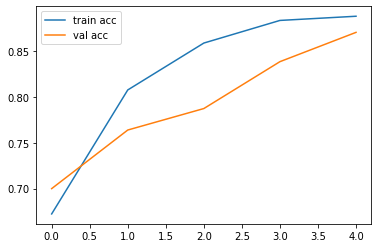

<Figure size 432x288 with 0 Axes>

In [15]:
plt.plot(history_cnn.history['accuracy'], label = 'train acc')
plt.plot(history_cnn.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()
plt.savefig('AccVaal_acc')